[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sensioai/nbs/blob/master/mlp.ipynb)

# The Multilayer Perceptron

## Data

In [1]:
import numpy as np
from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data[:, (2, 3)]  # petal length, petal width
X_mean, X_std = X.mean(), X.std()
X_norm = (X - X_mean) / X_std

y = iris.target 

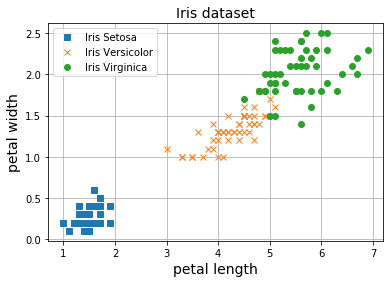

In [2]:
import matplotlib.pyplot as plt

plt.plot(X[y==0, 0], X[y==0, 1], 's', label="Iris Setosa")
plt.plot(X[y==1, 0], X[y==1, 1], 'x', label="Iris Versicolor")
plt.plot(X[y==2, 0], X[y==2, 1], 'o', label="Iris Virginica")
plt.grid()
plt.legend()
plt.xlabel('petal length', fontsize=14)
plt.ylabel('petal width', fontsize=14)
plt.title("Iris dataset", fontsize=14)
plt.show()

## Binary classification

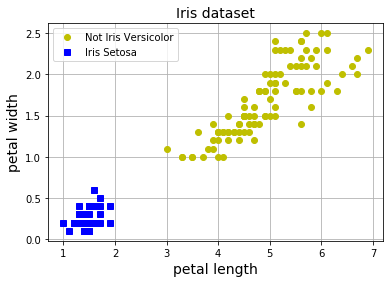

In [3]:
y = (iris.target == 0).astype(np.int)

plt.plot(X[y==0, 0], X[y==0, 1], 'yo', label="Not Iris Versicolor")
plt.plot(X[y==1, 0], X[y==1, 1], 'bs', label="Iris Setosa")
plt.grid()
plt.legend()
plt.xlabel('petal length', fontsize=14)
plt.ylabel('petal width', fontsize=14)
plt.title("Iris dataset", fontsize=14)
plt.show()

In [4]:
def relu(x):
  return np.maximum(0, x)

def reluPrime(x):
  return x > 0

def mse(output, target):
    return 0.5*(output - target)**2
  
def grad_mse(output, target):  
    return (output - target)

class MLP():
  def __init__(self, D_in, H, D_out):
    self.w1 = np.random.rand(D_in+1, H)
    self.w2 = np.random.rand(H+1, D_out)
    self.w1s, self.w2s = [], []
    self.loss = mse
    self.grad_loss = grad_mse

  def __call__(self, x):
    self.h = relu(np.dot(x, self.w1))
    self.h = np.c_[np.ones(len(self.h)), self.h]
    y_hat = np.dot(self.h, self.w2)  
    return self.final_activation(y_hat)

  def final_activation(self, x):
    return x > 0
    
  def fit(self, X, Y, epochs = 100, lr = 0.001):
    X = np.c_[np.ones(len(X)), X]
    for e in range(epochs):    
      l = []
      for x, y in zip(X, Y):            
        x = x[None,:]        
        y_pred = self(x) 
        # calcular función de pérdida
        loss = self.loss(y_pred, y).mean()
        l.append(loss)        
        # Backprop 
        # d loss / d output
        dldo = self.grad_loss(y_pred, y)        
        # d loss / d w2 = d loss / d output * d output / d w2
        grad_w2 = np.dot(self.h.T, dldo)
        # d loss / d relu = d loss / d output * d output / d relu 
        dldr = np.dot(dldo, self.w2[1:].T)*reluPrime(self.h[:,1:])      
        # d loss / d w1
        grad_w1 = np.dot(x.T, dldr)
        # Update de los pesos
        self.w1 = self.w1 - lr * grad_w1
        self.w2 = self.w2 - lr * grad_w2
      self.w1s.append(self.w1.copy())
      self.w2s.append(self.w2.copy())
      if not e % 10 and not e == 0:
        print(f'Epoch: {e}, Loss: {np.mean(l):.8f}')
    print(f'Epoch: {e+1}, Loss: {np.mean(l):.8f}')

  def predict(self, w1, w2, x):
    x = np.c_[np.ones(len(x)), x]
    h = relu(np.dot(x, w1))
    h = np.c_[np.ones(len(h)), h]
    y_hat = np.dot(h, w2)
    return self.final_prediction_activation(y_hat)

  def final_prediction_activation(self, x):
    return x > 0

In [5]:
mlp = MLP(2, 3, 1)
epochs, lr = 50, 0.001
mlp.fit(X_norm, y, epochs, lr)

Epoch: 10, Loss: 0.03666667
Epoch: 20, Loss: 0.01000000
Epoch: 30, Loss: 0.00000000
Epoch: 40, Loss: 0.00000000
Epoch: 50, Loss: 0.00000000


In [6]:
from matplotlib import animation, rc
rc('animation', html='html5')

def plot(epoch, w1, w2, X, y, axes, label):
    ax.clear()
    tit = ax.set_title(f"Epoch {epoch+1}", fontsize=14)
    x0, x1 = np.meshgrid(
            np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
            np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
        )
    
    X_new = (np.c_[x0.ravel(), x1.ravel()] - X_mean)/X_std
    y_predict = mlp.predict(w1, w2, X_new)
    zz = y_predict.reshape(x0.shape)

    ax.plot(X[y==0, 0], X[y==0, 1], "bs", label=f"Not {label}")
    ax.plot(X[y==1, 0], X[y==1, 1], "yo", label=f"{label}")

    from matplotlib.colors import ListedColormap
    custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

    ax.contourf(x0, x1, zz, cmap=custom_cmap)
    ax.set_xlabel("Petal length", fontsize=14)
    ax.set_ylabel("Petal width", fontsize=14)
    ax.legend(loc="lower right", fontsize=14)
    ax.axis(axes)
    return [tit]

def get_anim(fig, ax, mlp, X, y, axes = [0, 5, 0, 2], label="Iris-Setosa"):
    def anim(i):
        return plot(i, mlp.w1s[i], mlp.w2s[i], X, y, axes, label)
    return anim

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111, autoscale_on=False)
animate = get_anim(fig, ax, mlp, X, y)
anim = animation.FuncAnimation(fig, animate, frames=epochs, interval=100, blit=True)
plt.close()
anim

In [7]:
X2 = X[iris.target != 0]
X2_norm = (X2 - X_mean) / X_std

y2 = (iris.target == 1).astype(np.int)[iris.target != 0]

In [8]:
mlp = MLP(2, 3, 1)
epochs, lr = 50, 0.001
mlp.fit(X2_norm, y2, epochs, lr)

Epoch: 10, Loss: 0.03500000
Epoch: 20, Loss: 0.03000000
Epoch: 30, Loss: 0.03000000
Epoch: 40, Loss: 0.03000000
Epoch: 50, Loss: 0.03000000


In [9]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111, autoscale_on=False)
animate = get_anim(fig, ax, mlp, X2, y2, axes = [2.5, 7.5, 0.5, 2.8], label="Iris-Versicolor")
anim = animation.FuncAnimation(fig, animate, frames=epochs, interval=100, blit=True)
plt.close()
anim

## Multi-class Classification

In [10]:
def crossentropy(output, target):
    logits = output[np.arange(len(output)),target]
    entropy = - logits + np.log(np.sum(np.exp(output),axis=-1))
    return entropy
  
def softmax(x):
    return np.exp(x) / np.exp(x).sum(axis=-1,keepdims=True)

def grad_crossentropy(output, target):
    answers = np.zeros_like(output)
    answers[np.arange(len(output)),target] = 1    
    return (- answers + softmax(output)) / output.shape[0]

class MLP2(MLP):
  def __init__(self, D_in, H, D_out):
    super().__init__(D_in, H, D_out)
    self.loss = crossentropy
    self.grad_loss = grad_crossentropy

  def final_activation(self, x):
    return x

  def final_prediction_activation(self, x):
    return np.argmax(softmax(x), axis=1) 

In [11]:
Y = iris.target

mlp = MLP2(2, 3, 3)
epochs, lr = 50, 0.01
mlp.fit(X_norm, Y, epochs, lr)

Epoch: 10, Loss: 0.29396342
Epoch: 20, Loss: 0.16246827
Epoch: 30, Loss: 0.11811074
Epoch: 40, Loss: 0.09824293
Epoch: 50, Loss: 0.08874295


In [12]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(epoch, X, y, classifier, w1, w2, resolution=0.02):
    ax.clear()
    tit = ax.set_title(f"Epoch {epoch+1}", fontsize=14)
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    X_new = (np.array([xx1.ravel(), xx2.ravel()]) - X_mean)/X_std
    Z = classifier.predict(w1, w2, X_new.T)
    #print(Z)
    Z = Z.reshape(xx1.shape)
    ax.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    ax.set_xlim(xx1.min(), xx1.max())
    ax.set_ylim(xx2.min(), xx2.max())
    ax.set_xlabel('petal length', fontsize=14)
    ax.set_ylabel('petal width', fontsize=14)
    classes = ["Iris-Setosa", "Iris-Versicolor", "Iris-Virginica"]
    for idx, cl in enumerate(np.unique(y)):
        ax.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=classes[cl], 
                    edgecolor='black')
    ax.legend(loc='upper left', fontsize=14)
    return [tit]
        
def get_anim(fig, ax, X, y, model):
    def anim(i):
        return plot_decision_regions(i, X, y, model, model.w1s[i], model.w2s[i])
    return anim

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111, autoscale_on=False)
animate = get_anim(fig, ax, X, Y, mlp)
anim = animation.FuncAnimation(fig, animate, frames=epochs, interval=100, blit=True)
plt.close()
anim

## MLP Framework

Build a Python module to be able to solve the problems with the following API

```
D_in, H, D_out = 2, 3, 2

mlp = MLP([
    Linear(D_in, H),
    ReLU(),
    Linear(H, D_out)
])

optimizer = SGD(mlp, lr=0.1)
loss = CrossEntropy(mlp)

epochs = 100
for e in range(epochs):
  for x, y in zip(X, Y):
    y_pred = mlp(x)    
    loss(y_pred, y)
    loss.backward()    
    optimizer.update()
```

In [13]:
# you should have a python module called mlp
# with all the functions defined

from mlp import *

In [14]:
D_in, H, D_out = 2, 30, 3

mlp = MLP([
    Linear(D_in, H),
    ReLU(),
    Linear(H, D_out)
])

optimizer = SGD(mlp, lr=0.1)
loss = CrossEntropy(mlp)

In [15]:
epochs = 30
for e in range(1,epochs+1):
  l = []
  for x, y in zip(X_norm, Y):            
    x = x[None,:]      
    y_pred = mlp(x)    
    l.append(loss(y_pred, y))
    loss.backward()    
    optimizer.update()
  print(f'Epoch: {e}, Loss: {np.mean(l):.4f}')

Epoch: 1, Loss: 0.1712
Epoch: 2, Loss: 0.1315
Epoch: 3, Loss: 0.0953
Epoch: 4, Loss: 0.0722
Epoch: 5, Loss: 0.0585
Epoch: 6, Loss: 0.0499
Epoch: 7, Loss: 0.0469
Epoch: 8, Loss: 0.0461
Epoch: 9, Loss: 0.0454
Epoch: 10, Loss: 0.0447
Epoch: 11, Loss: 0.0439
Epoch: 12, Loss: 0.0436
Epoch: 13, Loss: 0.0426
Epoch: 14, Loss: 0.0417
Epoch: 15, Loss: 0.0410
Epoch: 16, Loss: 0.0403
Epoch: 17, Loss: 0.0396
Epoch: 18, Loss: 0.0391
Epoch: 19, Loss: 0.0387
Epoch: 20, Loss: 0.0382
Epoch: 21, Loss: 0.0378
Epoch: 22, Loss: 0.0375
Epoch: 23, Loss: 0.0373
Epoch: 24, Loss: 0.0372
Epoch: 25, Loss: 0.0370
Epoch: 26, Loss: 0.0370
Epoch: 27, Loss: 0.0370
Epoch: 28, Loss: 0.0369
Epoch: 29, Loss: 0.0369
Epoch: 30, Loss: 0.0369


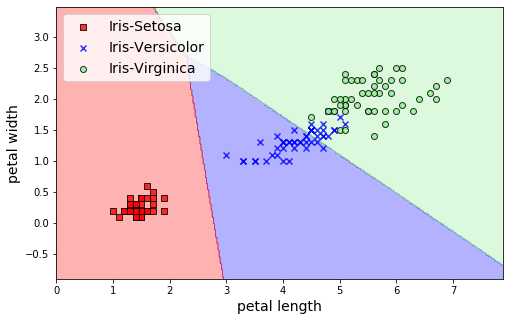

In [16]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111, autoscale_on=False)
# plot the decision surface
x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, 0.02),
                       np.arange(x2_min, x2_max, 0.02))
X_new = (np.array([xx1.ravel(), xx2.ravel()]) - X_mean)/X_std
Z = mlp(X_new.T)
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx1.shape)
colors = ('red', 'blue', 'lightgreen')
cmap = ListedColormap(colors[:len(np.unique(Y))])
ax.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
ax.set_xlim(xx1.min(), xx1.max())
ax.set_ylim(xx2.min(), xx2.max())
ax.set_xlabel('petal length', fontsize=14)
ax.set_ylabel('petal width', fontsize=14)
markers = ('s', 'x', 'o', '^', 'v')
classes = ["Iris-Setosa", "Iris-Versicolor", "Iris-Virginica"]
for idx, cl in enumerate(np.unique(Y)):
        ax.scatter(x=X[Y == cl, 0], 
                    y=X[Y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=classes[cl], 
                    edgecolor='black')
ax.legend(loc='upper left', fontsize=14)
plt.show()

Explore the effect of the number of layers, activation functions, etc ... here: https://playground.tensorflow.org/